In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime 
from dateutil.relativedelta import relativedelta

%matplotlib inline 

pd.set_option('display.max_columns', 100)

# Introduction
I wanted to invest my money in the stock market, but there were too many stocks to choose from. I would like to segment the thousands of stocks that are available and filter out the group of better performing stocks. I shall attempt to use K-means clustering to solve this problem.

### What is K-means clustering?
K-means clustering is a type of unsupervised learning model. Unsupervised models are used to learn from a data set that is not labeled or classified. It identifies commonalities in the data set and react based on the presence or absence of such commonalities in each data point.

The objective of this model is to form clusters in the data set, with the number of clusters represented by the variable K. Data points are assigned to one of the K groups based on feature similarity.

### How does K-means clustering works?
1. K number of cluster centroids are initialized randomly
2. Data points that are near to the cluster centroids are assigned to that cluster
3. The centroids will then move to the average point in the cluster and the data points will be re-assigned again
4. Step 1 and 2 will be repeated until there is no change in the clusters.

# Data Transformation
I have decided to use annual returns and variance as my variables as they informed users of the stock performance and its volatility. To narrow down my scope, I would be using stocks listed on NASDAQ and NYSE.

In [68]:
# 2006 - 2017 raw data is taken from Stocker python package which pulls from Quandl API
raw_data = pd.read_csv('./agg_df2_2012_onwards.csv')

In [69]:
raw_data.head()

,ticker,date,year,open,close
0,DDD,2012-01-03,2012.0,14.85,15.36
1,DDD,2012-01-04,2012.0,15.23,15.49
2,DDD,2012-01-05,2012.0,15.42,16.09
3,DDD,2012-01-06,2012.0,16.12,16.01
4,DDD,2012-01-09,2012.0,16.00,15.81


In [70]:
# 2018 raw data is taken from yahoo-finance package
df_2018 = pd.read_csv('./2018_data.csv', index_col=0)

In [71]:
df_2018.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,ticker
0,2018-01-02,8.70,9.11,8.60,9.06,9.06,2499000,DDD
1,2018-01-03,9.12,9.37,9.10,9.31,9.31,1799100,DDD
2,2018-01-04,9.35,9.45,9.09,9.36,9.36,1982200,DDD


In [72]:
# narrowing dataset to 2012 - 2017
# creating new column `year`
df_2012_2017 = (
    raw_data
    .pipe(lambda x: x.assign(year=pd.to_datetime(x.date).dt.year))
    .query("year >= 2012")
    [['ticker', 'date', 'year', 'open', 'close']]
)

`df_2012_2017` dataset provides the data for each stock performance on a daily basis, during the stated time period. I would like to obtain the annual performance of each stock to calculate the average annual return and variance.

### For those who are unfamiliar, average yearly return can be calculated in 3 steps:
1. Calculate annual return of each year by subtracting the closing price of a stock on the last trading day in the year with the opening price of the same stock on the first trading day in the same year.
2. Divide the value in step 1 by the opening price of the stock on the first trading day in the same year. You would obtain the annual return for that year. Repeat step 1 and 2 for X number of years you have.
3. Sum up all the annual returns in the stated time period and divide the value by X number of years.

### To calculate variance:
1. subtract each year's annual return with the average annual return and square that value. 
2. Sum all the values in step 1 and divide it by X years.

As such, I would need to transform my data set to based on the above parameters to obtain my desired variables. 

In [73]:
# Getting the first and last trading day of each year
first_date_list = [df_2012_2017.query(f"year == {year}").date.min() for year in range(2012, 2018)]
last_date_list = [df_2012_2017.query(f"year == {year}").date.max() for year in range(2012, 2018)]

# Create DataFrames for first and last dates
first_date_df = pd.DataFrame({"date": first_date_list})
last_date_df = pd.DataFrame({"date": last_date_list})

print(first_date_df)
print(last_date_df)


         date
0  2012-01-03
1  2013-01-02
2  2014-01-02
3  2015-01-02
4  2016-01-04
5  2017-01-03
         date
0  2012-12-31
1  2013-12-31
2  2014-12-31
3  2015-12-31
4  2016-12-30
5  2017-12-29


In [74]:
# Filtering for the first day data in `df_2012_2017`
first_date_2012_2017_df = (
    df_2012_2017
    .merge(first_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=pd.to_datetime(x['date']).dt.year))
    .rename(columns={"open": "open_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)
print(first_date_2012_2017_df.head())

# Filtering for the last day data in `df_2012_2017`
last_date_2012_2017_df = (
    df_2012_2017
    .merge(last_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=pd.to_datetime(x['date']).dt.year))
    .rename(columns={"close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)
print(last_date_2012_2017_df.head())


  ticker   2012   2013    2014    2015    2016    2017
0      A  35.84  42.17   57.10   41.18   41.06   45.93
1    AAN  27.23  28.72   29.43   30.81   22.11   32.40
2    AAP  71.14  73.49  110.36  160.85  149.25  170.78
3    ABC  37.77  43.59   70.11   90.61  102.31   78.51
4    ABG  22.04  32.48   53.70   76.59   66.17   62.70
  ticker   2012    2013    2014    2015    2016   2017
0      A  40.94   57.19   40.94   41.81   45.56  66.97
1    AAN  28.28   29.40   30.57   22.39   31.99  39.85
2    AAP  72.35  110.68  159.28  150.51  169.12  99.69
3    ABC  43.18   70.31   90.16  103.71   78.19  91.82
4    ABG  32.03   53.74   75.92   67.44   61.70  64.00


In [75]:
# Filtering for the first day data in `df_2012_2017`
first_date_2012_2017_df = (
    df_2012_2017
    .merge(first_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=pd.to_datetime(x['date']).dt.year))
    .rename(columns={"open": "open_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)
print(first_date_2012_2017_df.head())

# Filtering for the last day data in `df_2012_2017`
last_date_2012_2017_df = (
    df_2012_2017
    .merge(last_date_df, on='date', how='inner')
    .pipe(lambda x: x.assign(year=pd.to_datetime(x['date']).dt.year))
    .rename(columns={"close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)
print(last_date_2012_2017_df.head())


  ticker   2012   2013    2014    2015    2016    2017
0      A  35.84  42.17   57.10   41.18   41.06   45.93
1    AAN  27.23  28.72   29.43   30.81   22.11   32.40
2    AAP  71.14  73.49  110.36  160.85  149.25  170.78
3    ABC  37.77  43.59   70.11   90.61  102.31   78.51
4    ABG  22.04  32.48   53.70   76.59   66.17   62.70
  ticker   2012    2013    2014    2015    2016   2017
0      A  40.94   57.19   40.94   41.81   45.56  66.97
1    AAN  28.28   29.40   30.57   22.39   31.99  39.85
2    AAP  72.35  110.68  159.28  150.51  169.12  99.69
3    ABC  43.18   70.31   90.16  103.71   78.19  91.82
4    ABG  32.03   53.74   75.92   67.44   61.70  64.00


In [84]:
# Transforming 2018 data to be similar to the `first_date_2012_2017` and `last_date_2012_2017` dataframe
first_date_2018_df = (
    df_2018
    .query("Date == '2018-01-03'")
    [['ticker', 'Date', 'Open']]
    .pipe(lambda x: x.assign(year=pd.to_datetime(x['Date']).dt.year))
    .rename(columns={"Open": "open_first_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'open_first_day']]
    .pivot_table(values='open_first_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)
last_trading_date = df_2018[df_2018['Date'].between('2018-12-24', '2018-12-31')]['Date'].max()

last_date_2018_df = (
    df_2018
    .query(f"Date == '{last_trading_date}'")
    [['ticker', 'Date', 'Close']]
    .pipe(lambda x: x.assign(year=pd.to_datetime(x['Date']).dt.year))
    .rename(columns={"Close": "close_last_day"})
    .reset_index(drop=True)
    [['ticker', 'year', 'close_last_day']]
    .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
    .rename_axis(None, axis=1)
    .reset_index()
)
# last_date_2018_df = (
#     df_2018
#     .query("Date == '2018-12-29'")
#     [['ticker', 'Date', 'Close']]
#     .pipe(lambda x: x.assign(year=pd.to_datetime(x['Date']).dt.year))
#     .rename(columns={"Close": "close_last_day"})
#     .reset_index(drop=True)
#     [['ticker', 'year', 'close_last_day']]
#     .pivot_table(values='close_last_day', columns='year', index='ticker', aggfunc='sum')
#     .rename_axis(None, axis=1)
#     .reset_index()
# )

print(last_date_2018_df.head())
print(first_date_2018_df.head())


  ticker        2018
0      A   65.959999
1     AA   26.600000
2    AAP  155.460007
3    AAT   40.070000
4     AB   26.820000
  ticker        2018
0      A   67.620003
1     AA   54.919998
2    AAP  106.419998
3    AAT   38.189999
4     AB   25.150000


In [85]:
# Merging 2012-2017 data with 2018 data
merged_df = first_date_2012_2017_df.merge(first_date_2018_df, on='ticker', how='inner', suffixes=('', '_2018'))

# Print the columns to see what we have
print("Columns after merging 2012-2017 data with 2018 data:")
print(merged_df.columns)
# Convert the year columns to strings
merged_df.columns = merged_df.columns.map(str)

# Now perform the melt operation
agg_first_date_df = (
    merged_df
    .melt(id_vars='ticker', value_vars=[str(year) for year in range(2012, 2019)])
    .rename(columns={"variable": "year", "value": "open_first_day"})
)

print(agg_first_date_df.head())



Columns after merging 2012-2017 data with 2018 data:
Index(['ticker', '2012', '2013', '2014', '2015', '2016', '2017', 2018], dtype='object')
  ticker  year  open_first_day
0      A  2012           35.84
1    AAP  2012           71.14
2    ABG  2012           22.04
3    ABM  2012           21.07
4    ABT  2012           56.58


In [86]:
# Convert the year columns to strings before merging
first_date_2012_2017_df.columns = first_date_2012_2017_df.columns.map(str)
first_date_2018_df.columns = first_date_2018_df.columns.map(str)
last_date_2012_2017_df.columns = last_date_2012_2017_df.columns.map(str)
last_date_2018_df.columns = last_date_2018_df.columns.map(str)

# Ensure 2018 column is present in both first_date_2018_df and last_date_2018_df
print("Columns in first_date_2018_df:", first_date_2018_df.columns)
print("Columns in last_date_2018_df:", last_date_2018_df.columns)

# Merging 2012-2017 data with 2018 data for first dates
agg_first_date_df = (
    first_date_2012_2017_df
    .merge(first_date_2018_df, on='ticker', how='inner')
    .melt(id_vars='ticker', value_vars=[str(year) for year in range(2012, 2019) if str(year) in first_date_2012_2017_df.columns])
    .rename(columns={"variable": "year", "value": "open_first_day"})
)

# Merging 2012-2017 data with 2018 data for last dates
agg_last_date_df = (
    last_date_2012_2017_df
    .merge(last_date_2018_df, on='ticker', how='inner')
    .melt(id_vars='ticker', value_vars=[str(year) for year in range(2012, 2019) if str(year) in last_date_2012_2017_df.columns])
    .rename(columns={"variable": "year", "value": "close_last_day"})
)

# Displaying the resulting DataFrames
print(agg_first_date_df.head())
print(agg_last_date_df.head())


Columns in first_date_2018_df: Index(['ticker', '2018'], dtype='object')
Columns in last_date_2018_df: Index(['ticker', '2018'], dtype='object')
  ticker  year  open_first_day
0      A  2012           35.84
1    AAP  2012           71.14
2    ABG  2012           22.04
3    ABM  2012           21.07
4    ABT  2012           56.58
  ticker  year  close_last_day
0      A  2012           40.94
1    AAP  2012           72.35
2    ABG  2012           32.03
3    ABM  2012           19.95
4    ABT  2012           65.50


In [87]:
# calculating yearly return and then averaging them to get average yearly returns for each stock
agg_gains_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    .groupby("ticker")
    .agg({"gains_pctg": "mean"})
    .reset_index()
    .rename(columns={"gains_pctg": "avg_yearly_returns"})
)

# calculating overall variance using each year's return
agg_var_df = (
    agg_first_date_df
    .merge(agg_last_date_df, on=['ticker', 'year'], how='inner')
    .pipe(lambda x: x.assign(gains_dollar=x.close_last_day-x.open_first_day))
    .pipe(lambda x: x.assign(gains_pctg=x.gains_dollar/x.open_first_day))
    [['ticker', 'gains_pctg']]
    .groupby("ticker")
    .agg(np.var)
    .reset_index()
    .rename(columns={"gains_pctg": "yearly_variance"})
)

agg_df3 = (
    agg_gains_df
    .merge(agg_var_df, on='ticker', how='inner')
)

C:\Users\mohan\AppData\Local\Temp\ipykernel_22228\1601912589.py:21: FutureWarning: The provided callable <function var at 0x0000022DFF7A8EA0> is currently using DataFrameGroupBy.var. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "var" instead.
  .agg(np.var)


In [88]:
agg_df3.head()

,ticker,avg_yearly_returns,yearly_variance
0,A,0.133075,0.068609
1,AAP,0.103154,0.116833
2,ABG,0.225886,0.103646
3,ABM,0.124226,0.058813
4,ABT,0.145022,0.042051


In [89]:
agg_df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 724 entries, 0 to 723
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ticker              724 non-null    object 
 1   avg_yearly_returns  724 non-null    float64
 2   yearly_variance     724 non-null    float64
dtypes: float64(2), object(1)
memory usage: 17.1+ KB


1300 stocks will be used for this study.

# Modelling

### Evaluation
Typically, two metrics are used to evaluate a K-means model. 
1. Sum of square errors (SSE) within clusters
2. Silhouette score.

SSE within clusters is derived by summing up the squared distance between each data point and its closest centroid. The goal is to reduce the error value. The intuition behind this is that we would want the distance of each data point to be as close as possible to the centroid. If the error is small, it would mean that the data points in the same cluster are relatively similar. As the number of centroids (clusters) increase, the error value will decrease. As such we would need to rely on the next metric to ensure that we are not introducing too many centroids (clusters) in the model.

Silhouette score is a measure of how similar the data point is to its own cluster compared to other clusters. The value ranges from -1 (worst score) to 1 (best score). A negative value would mean that data points are wrongly clustered while values near 0 would mean that there are overlapping clusters.

In [90]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

In [91]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt

def plot_cluster(df, max_loop=50):
    """
    Looking at the performance of various number of clusters using K-Means.
    Performance is evaluated by within cluster SSE and silhouette score.
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        pass  # Use 'pass' instead of 'next'
    
    X = df.iloc[:, 1:]
    
    # Robust scaling to avoid influence of outliers
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    sse_within_cluster = {}
    silhouette_score = {}
    
    for k in range(2, max_loop):
        kmeans = KMeans(n_clusters=k, random_state=10, n_init=10)
        kmeans.fit(X_rb)
        sse_within_cluster[k] = kmeans.inertia_
        silhouette_score[k] = metrics.silhouette_score(X_rb, kmeans.labels_)

    # Plotting the SSE within clusters
    plt.figure(figsize=(10, 6))
    
    ax1 = plt.subplot(211)
    plt.plot(list(sse_within_cluster.keys()), list(sse_within_cluster.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE Within Cluster")
    plt.title("Within Cluster SSE After K-Means Clustering")
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    # Plotting the silhouette score
    ax2 = plt.subplot(212)
    plt.plot(list(silhouette_score.keys()), list(silhouette_score.values()))
    plt.xlabel("Number of Clusters")
    plt.ylabel("Silhouette Score")
    plt.title("Silhouette Score After K-Means Clustering")
    plt.xticks([i for i in range(2, max_loop)], rotation=75)
    
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.5, wspace=0.35)
    plt.show()

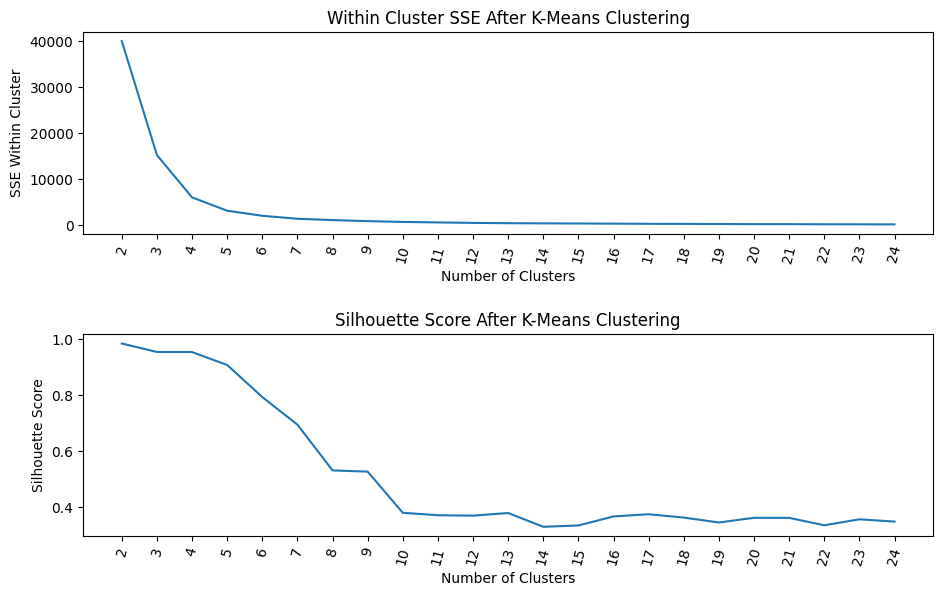

In [92]:
plot_cluster(agg_df3, max_loop=25)

From the first graph, `Within Cluster SSE After K-Means Clustering`, we can see that as the number of clusters increase pass 7, the sum of square of errors within clusters plateaus off. From the second graph, `Silhouette Score After K-Means Clustering`, we can see that there are various parts of the graph where a kink can be seen. Since there is not much a difference in SSE after 7 clusters and that the drop in sihouette score is quite significant between 14 clusters and 15 clusters, I would use 14 clusters in my K-Means model below.

In [93]:
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import KMeans
from sklearn import metrics

def apply_cluster(df, clusters=2):
    """
    Applying K-Means with the optimal number of clusters identified
    """
    try:
        df.drop('cluster', axis=1, inplace=True)
    except:
        pass
    
    X = df.iloc[:, 1:]
    rb = RobustScaler()
    X_rb = rb.fit_transform(X)
    
    # Remove n_jobs as it's no longer supported
    kmeans = KMeans(n_clusters=clusters, random_state=10, n_init=10)
    kmeans.fit(X_rb) 
    
    score = metrics.silhouette_score(X_rb, kmeans.labels_)
    df['cluster'] = kmeans.labels_
    sse_within_cluster = kmeans.inertia_
    
    print("Clustering Performance")
    print("-----------------------------------")
    print("Silhouette Score: " + str(round(score, 2)))
    print("SSE Within Cluster: " + str(round(sse_within_cluster, 2)))
    
    return df

In [94]:
first_trial = apply_cluster(agg_df3, clusters=14)

Clustering Performance
-----------------------------------
Silhouette Score: 0.33
SSE Within Cluster: 399.21


In [95]:
cluster_perf_df = (
    first_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

cluster_perf_df

,cluster,avg_yearly_returns,yearly_variance,ticker
0,6,0.006718,0.178340,69
1,9,0.011839,0.050043,155
2,12,0.127027,0.047878,258
3,0,0.234015,0.046682,107
4,5,0.242312,0.384672,38
5,10,0.283981,0.162586,66
6,11,0.294336,0.809623,12
7,13,0.346955,1.458737,4
8,7,0.520547,3.594622,3
9,4,0.548792,2.118475,4


From the dataframe above, we can see that the distribution of the stocks amongst the clusters is very skewed. Most of the stocks are aggregated in cluster `0`. For the other clusters, we can see that the `avg_yearly_returns` and `variance` are huge. A savvy investor would definitely not invest in these other clusters as the swing is too big, ranging from ~102% to 65100%. As such, he/she would most probably invest in a stock in cluster 0. As cluster 0 still contains too many stocks to choose from, I will attempt to conduct another K-Means clustering on cluster `0`.

In [96]:
# creating a dataframe that only consists of cluster `0`
agg_df3_sub = agg_df3.query("cluster == 0").reset_index(drop=True)

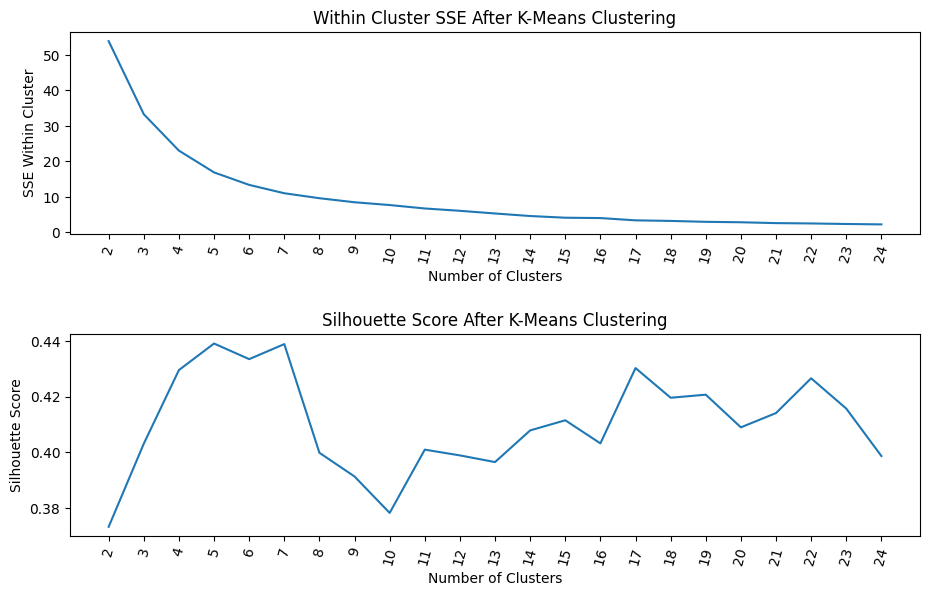

In [97]:
plot_cluster(agg_df3_sub, max_loop=25)

From the second graph, `Silhouette Score After K-Means Clustering`, we can see that there was a steep drop in silhouette score between 5 clusters and 6 clusters. As such, I would use 5 clusters in my K-Means model below.

In [98]:
second_trial= apply_cluster(agg_df3_sub, clusters=5)

Clustering Performance
-----------------------------------
Silhouette Score: 0.44
SSE Within Cluster: 16.91


In [99]:
sub_cluster_perf_df = (
    second_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)

sub_cluster_perf_df

,cluster,avg_yearly_returns,yearly_variance,ticker
0,0,0.203378,0.022914,32
1,1,0.207748,0.091610,11
2,2,0.217296,0.054390,31
3,3,0.279938,0.026106,18
4,4,0.298079,0.073204,15


From the dataframe above, we can see that cluster `0` and cluster `2` would be the 2 better clusters to invest, amongst the rest. Cluster `0` yields a decent return of 8.1% with a 5.3% variance, while cluster `2` yields a much higher return of 20.7%, with a correspondingly higher variance of 11.6%. I decided to add in Sharpe Ratio as a metric to better evaluate the cluster performance.

### What is Sharpe Ratio?
Sharpe Ratio is used to help investors understand the return of an investment compared to its risk. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. It is derived using annual returns, variance and risk-free rate. A Sharpe Ratio of more than 1 is considered good while a Sharpe Ratio of more than 2 is considered very good.

### How to compute Sharpe Ratio?
Sharpe Ratio can be computed as such:

**$Sharpe\ Ratio = (R_s - R_f) /{SD_s}$**

I will be using the first day of the year, 5-years daily U.S. yield rates, from https://home.treasury.gov/ as the risk-free rate.

In [100]:
# calculating the average risk free rate over the time period of 2012 - 2018 
us_yield_curve_5years_dict = {"year": [2012, 2013, 2014, 2015, 2016, 2017, 2018],
                         "risk_free_rate": [0.89, 0.76, 1.72, 1.61, 1.73, 1.94, 2.25]}
us_yield_curve_5years_df = pd.DataFrame.from_dict(us_yield_curve_5years_dict)

avg_risk_free_rate = (
    us_yield_curve_5years_df
    .mean()
    [['risk_free_rate']]
    [0]
)

C:\Users\mohan\AppData\Local\Temp\ipykernel_22228\449345941.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  us_yield_curve_5years_df


In [101]:
def get_sharpe_ratio_df(df):
    """
    Computing Sharpe Ratio
    """
    df_w_sharpe_ratio = (
        df
        .pipe(lambda x: x.assign(avg_risk_free_rate=avg_risk_free_rate/100))
        .pipe(lambda x: x.assign(std_dev=np.sqrt(x.yearly_variance)))
        .pipe(lambda x: x.assign(sharpe_ratio=(x.avg_yearly_returns-x.avg_risk_free_rate)/x.std_dev))
    )

    return df_w_sharpe_ratio

In [102]:
second_trial_w_sharpe_ratio = get_sharpe_ratio_df(second_trial)

In [103]:
def get_transform_df(df_w_sharpe_ratio):
    """
    Transforming dataframe so that I can plot a boxplot of `Returns`, `Variance` and `Sharpe Ratio` for each cluster
    """
    df_yearly_returns = (
        df_w_sharpe_ratio
        [['avg_yearly_returns', 'cluster']]
        .pipe(lambda x: x.assign(type='avg_yearly_returns'))
        .rename(columns={"avg_yearly_returns": "rate"})
    )

    df_variance = (
        df_w_sharpe_ratio
        [['yearly_variance', 'cluster']]
        .pipe(lambda x: x.assign(type='yearly_variance'))
        .rename(columns={"yearly_variance": "rate"})
    )

    df_sharpe_ratio = (
        df_w_sharpe_ratio
        [['sharpe_ratio', 'cluster']]
    )

    df_transform = pd.concat([df_yearly_returns, df_variance], axis=0)

    return df_transform, df_sharpe_ratio

In [104]:
sub_cluster_transform, sub_cluster_sharpe_ratio = get_transform_df(second_trial_w_sharpe_ratio)

In [105]:
def cluster_perf(transform_df, sharpe_ratio_df):
    """
    Plotting boxplot of cluster performance
    """
    _  = plt.figure(figsize=(15,7))

    ax1 = plt.subplot(121)
    _ = sns.boxplot(x='cluster', y='rate', hue='type', data=transform_df)
    _ = plt.title("Distribution of Returns and Variance for each Cluster")

    ax2 = plt.subplot(122)
    _ =sns.boxplot(x='cluster', y='sharpe_ratio', data=sharpe_ratio_df, color='royalblue')
    _ = plt.title("Distribution of Sharpe Ratio for each Cluster")

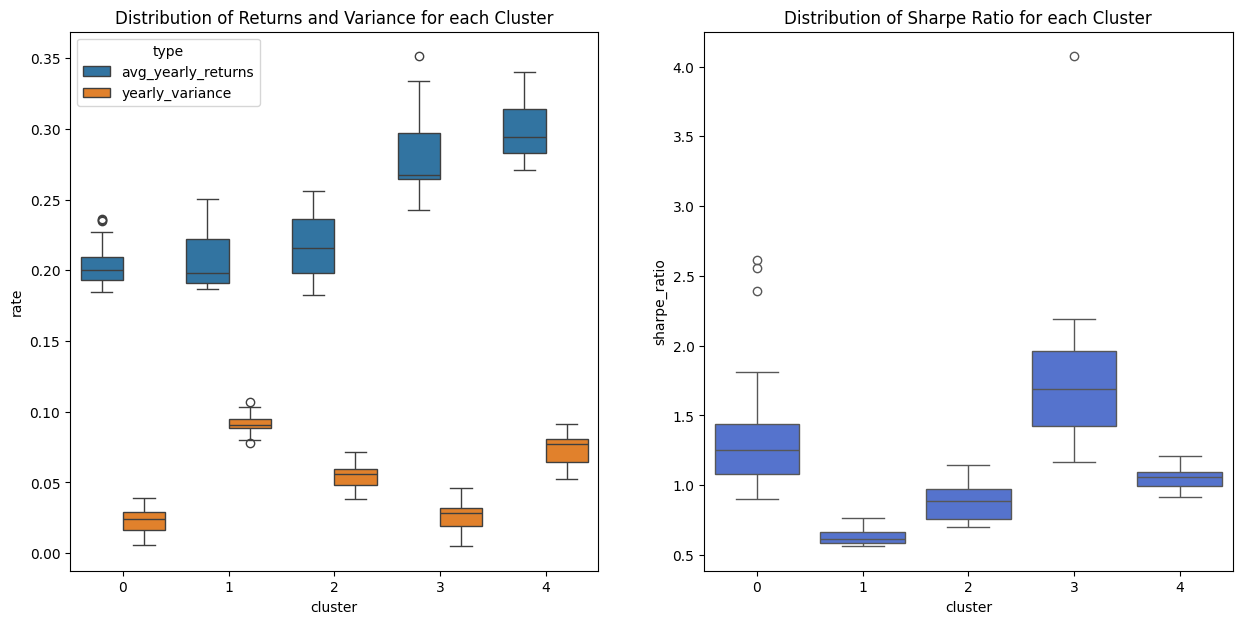

In [106]:
cluster_perf(sub_cluster_transform, sub_cluster_sharpe_ratio)

From the charts above, we can see that cluster `2` has the best Sharpe Ratio distribution amongst the rest and that its average returns (20.7%) and variance (11.6%) is still acceptable for my risk appetite. For someone who have a smaller risk appetite, he/she should be looking at cluster `0`, where the sharpe ratio is still fairly decent, along with moderate average returns (8.1%) and variance(5.3%)

Coupled with the fact that there are still more than 200 stocks in cluster `2` and there are some outliers (outperforming stocks) in that cluster, I would like to take segement it even further so that I can have a smaller group of stocks to research on.

In [107]:
(
    second_trial_w_sharpe_ratio
    .groupby("cluster")
    .agg({"avg_yearly_returns": "mean", "yearly_variance": "mean", "sharpe_ratio": "mean", "ticker": "count"})
    .reset_index()
)

,cluster,avg_yearly_returns,yearly_variance,sharpe_ratio,ticker
0,0,0.203378,0.022914,1.361951,32
1,1,0.207748,0.091610,0.635581,11
2,2,0.217296,0.054390,0.875515,31
3,3,0.279938,0.026106,1.796158,18
4,4,0.298079,0.073204,1.051590,15


In [108]:
# filtering out for cluster 1
best_sub_cluster = second_trial.query("cluster == 2")

C:\Users\mohan\AppData\Local\Temp\ipykernel_22228\11019684.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('cluster', axis=1, inplace=True)


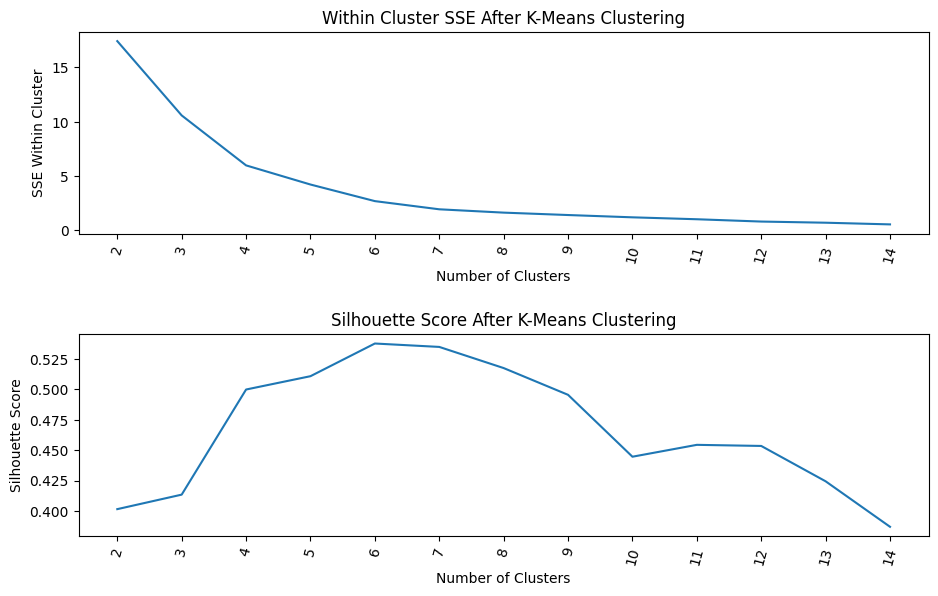

In [109]:
plot_cluster(best_sub_cluster, max_loop=15)

Based the above 2 graphs, I will use 6 clusters in my K-Means model below.

In [110]:
third_trial = apply_cluster(best_sub_cluster, clusters=6)

Clustering Performance
-----------------------------------
Silhouette Score: 0.54
SSE Within Cluster: 2.69


C:\Users\mohan\AppData\Local\Temp\ipykernel_22228\4098633206.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cluster'] = kmeans.labels_


In [111]:
best_sub_cluster_perf = (    
    third_trial
    .groupby('cluster')
    .agg({"avg_yearly_returns":"mean", "yearly_variance":"mean", "ticker":"count"})
    .sort_values('avg_yearly_returns')
    .reset_index()
)
best_sub_cluster_perf

,cluster,avg_yearly_returns,yearly_variance,ticker
0,2,0.193114,0.056201,9
1,0,0.198824,0.044306,3
2,5,0.213583,0.069878,4
3,4,0.231943,0.051243,5
4,3,0.232198,0.038882,4
5,1,0.243138,0.059349,6


In [112]:
third_trial_w_sharpe_ratio = get_sharpe_ratio_df(third_trial)

In [113]:
best_sub_cluster_transform, best_sub_cluster_sharpe_ratio = get_transform_df(third_trial_w_sharpe_ratio)

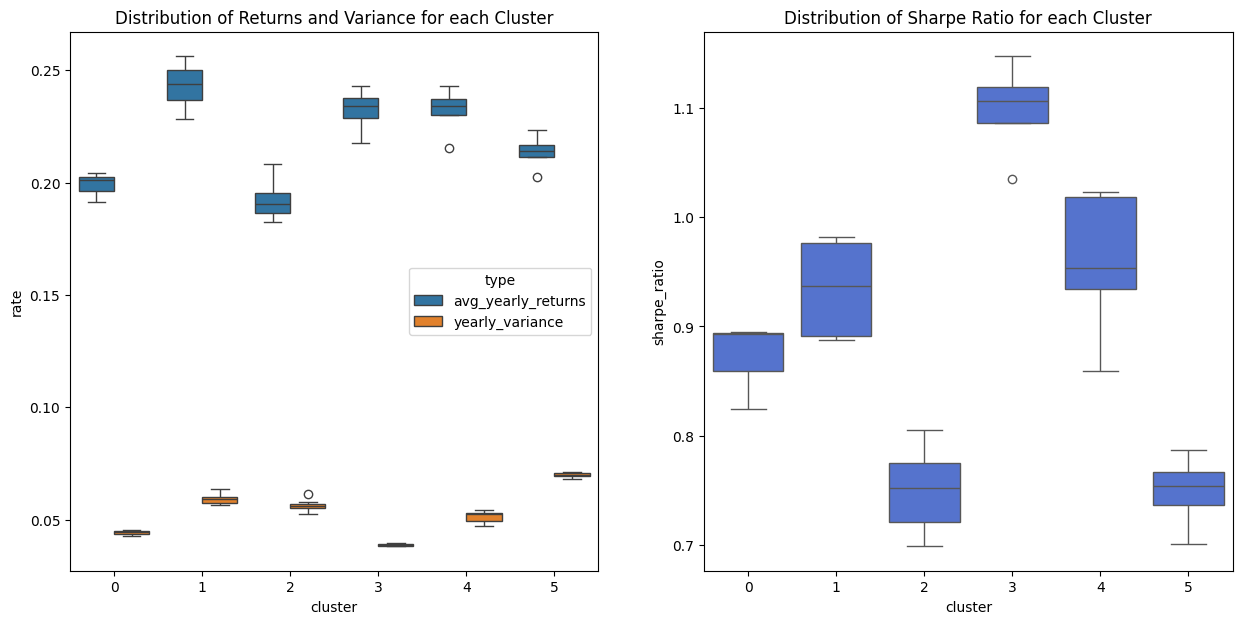

In [114]:
cluster_perf(best_sub_cluster_transform, best_sub_cluster_sharpe_ratio)

We can see that cluster `3` has the best sharpe ratio distribution and a very impressive average returns of 24.0% and variance of 5.0% (over the last 7 years). This golden cluster of 57 stocks definitely captured my attention and I should focused my research on them and create a portfolio based on them.

In [115]:
(
    third_trial_w_sharpe_ratio
    .groupby('cluster')
    .agg({"avg_yearly_returns": "mean", "yearly_variance": "mean", "sharpe_ratio": "mean", "ticker": "count"})
    .reset_index()
)

,cluster,avg_yearly_returns,yearly_variance,sharpe_ratio,ticker
0,0,0.198824,0.044306,0.870959,3
1,1,0.243138,0.059349,0.934674,6
2,2,0.193114,0.056201,0.749139,9
3,3,0.232198,0.038882,1.098395,4
4,4,0.231943,0.051243,0.957445,5
5,5,0.213583,0.069878,0.749250,4


In [116]:
third_trial.query("cluster == 3").ticker.unique()

array(['COO', 'HIG', 'ORA', 'SNA'], dtype=object)

# Conclusion
In the first iteration of K-Means clustering, 14 clusters were formed. 13 of those clusters had extremely high returns and variance, stocks where no savvy investors would have purchased. As such, I have decided to conduct a second iteration on the remaining cluster, cluster `0`, that contains a majority of the stocks (1193 out of 1300 stocks). 

In the second iteration of K-Means clustering of the sub-cluster, 5 clusters were formed. As the performance of the clusters were fairly close, I have introduced a new metric, Sharpe Ratio, to better evaluate the performance of each cluster. From the Sharpe Ratio boxplot, it can be seen that cluster `2` was the better performing cluster as its Sharpe Ratio distribution was on the higher end. Since cluster `2` compromised of 257 stocks (still a fairly large number of stocks to study) and that there are some outliers in the Sharpe Ratio, I would like to take a more in-depth look into it, to see whether can I further narrow down to form a golden cluster.

In my third iteration of K-Means clustering of the sub-sub-cluster, 6 clusters were formed. From this last iteration, we can see a clear winner. Cluster `3` has the best Sharp Ratio distribution and that it has an impressive average returns of 24.0% and a variance of 5.0%, over the last 7 years. I should focus my research on this cluster (57 stocks) and choose the best stocks to invest in, based on fundamental analysis.

# Limitations and Assumptions
1. The time period where there was a financial crisis (2007 and 2008) were not taken into account.
2. The volatility of each stocks within a year was not taken into account as well. The golden cluster's annual return could have a low variance of 5% in the 7 years period, but there could be huge movement in the stocks within a year.